In [1]:
import mnist
import os
import blosc
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqn
%matplotlib inline

In [2]:
src = './../MNIST_data'
with open(os.path.join(src, 'mnist_pics.blk'), 'rb') as file:
    images = blosc.unpack_array(file.read()).reshape(-1, 28, 28)
with open(os.path.join(src, 'mnist_labels.blk'), 'rb') as file:
    labels = blosc.unpack_array(file.read())

In [3]:
def create_train(opt, src, global_step, loss, it):
    def learning_rate(last, src):
        last = int(last)
        bound = list(np.linspace(0, last, len(range(2, last+1)), dtype=np.float32))
        values = [0.5 * 0.1/last* (1 + np.cos(np.pi * i / last)) for i in range(2, last+1)]
        var = [i for i in tf.trainable_variables() if src in i.name or 'dense' in i.name]
        return bound, values, var
    
    b, v, var = learning_rate(it, src)
    learning_rate = tf.train.piecewise_constant(global_step, b, v)
    
    return opt(learning_rate).minimize(loss, global_step, var)

In [4]:
it = 100
x = tf.placeholder(tf.float32, [None, 784], name='x')
x_as_pics = tf.reshape(x, shape=[-1, 28, 28, 1])


conv1_1 = tf.layers.conv2d(x_as_pics, 64, (3, 3), (1, 1), name='Conv1', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())

conv1_2 = tf.layers.conv2d(x_as_pics, 64, (3, 3), (1, 1), name='Conv2', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
pool1 = tf.layers.max_pooling2d(conv1_2, 2, 2)

conv2_1 = tf.layers.conv2d(x_as_pics, 128, (3, 3), (1, 1), name='Conv3', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
conv2_2 = tf.layers.conv2d(x_as_pics, 128, (3, 3), (1, 1), name='Conv4', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
pool2 = tf.layers.max_pooling2d(conv2_2, 2, 2)


conv3_1 = tf.layers.conv2d(x_as_pics, 256, (3, 3), (1, 1), name='Conv5', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
conv3_2 = tf.layers.conv2d(x_as_pics, 256, (3, 3), (1, 1), name='Conv6', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
conv3_3 = tf.layers.conv2d(x_as_pics, 256, (3, 3), (1, 1), name='Conv7', padding='SAME', \
                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
pool3 = tf.layers.max_pooling2d(conv3_3, 2, 2)

with tf.variable_scope('dense'):
    flat = tf.contrib.layers.flatten(pool3)
    fc4 = tf.layers.dense(flat, 512, activation=tf.nn.relu, name='fc4')

    fc5 = tf.layers.dense(fc4, 10, name='fc5')

    y = tf.placeholder(tf.float32, [None, 10])

prob = tf.nn.softmax(fc5)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=fc5, labels=y, name='loss'))

train = []
global_steps = []
for i in tqn(range(7)):
    global_steps.append(tf.Variable(0., trainable=False))
    train.append(create_train(tf.train.GradientDescentOptimizer, 'Conv' + str(i), \
                              global_steps[-1], loss, it*(i/10 + 0.4)))

lables_hat = tf.cast(tf.argmax(fc5, axis=1), tf.float32, name='lables_hat')
lables = tf.cast(tf.argmax(y, axis=1), tf.float32, name='lables')
accuracy = tf.reduce_mean(tf.cast(tf.equal(lables_hat, lables), tf.float32), name='acc')

In [5]:
tf.global_variables()

[<tf.Variable 'Conv1/kernel:0' shape=(3, 3, 1, 64) dtype=float32_ref>,
 <tf.Variable 'Conv1/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Conv2/kernel:0' shape=(3, 3, 1, 64) dtype=float32_ref>,
 <tf.Variable 'Conv2/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'Conv3/kernel:0' shape=(3, 3, 1, 128) dtype=float32_ref>,
 <tf.Variable 'Conv3/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Conv4/kernel:0' shape=(3, 3, 1, 128) dtype=float32_ref>,
 <tf.Variable 'Conv4/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'Conv5/kernel:0' shape=(3, 3, 1, 256) dtype=float32_ref>,
 <tf.Variable 'Conv5/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Conv6/kernel:0' shape=(3, 3, 1, 256) dtype=float32_ref>,
 <tf.Variable 'Conv6/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'Conv7/kernel:0' shape=(3, 3, 1, 256) dtype=float32_ref>,
 <tf.Variable 'Conv7/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'dense/fc4/kernel:0' shape=(50176, 512) dtype=float3

In [6]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [7]:
train

[<tf.Operation 'GradientDescent' type=AssignAdd>,
 <tf.Operation 'GradientDescent_1' type=AssignAdd>,
 <tf.Operation 'GradientDescent_2' type=AssignAdd>,
 <tf.Operation 'GradientDescent_3' type=AssignAdd>,
 <tf.Operation 'GradientDescent_4' type=AssignAdd>,
 <tf.Operation 'GradientDescent_5' type=AssignAdd>,
 <tf.Operation 'GradientDescent_6' type=AssignAdd>]

In [8]:
los, acc = [], []
var_i = []
for i in tqn(range(1, 300)):
    var, a, b = sess.run([train, tf.global_variables()[2], loss, accuracy],feed_dict={x:images[:100].reshape(-1, 784),
                                                                          y:labels[:100].reshape(-1,10)})[-3:]
    var_i.append(var)
    los.append(a)
    acc.append(b)

In [16]:
var_i[1]

array([[[[-0.00576056,  0.06357543,  0.09219205, -0.06201024,  0.05394873,
          -0.10050302,  0.08456382,  0.05643585, -0.07541488, -0.02778126,
           0.08650297,  0.04588746,  0.01799192, -0.00793448, -0.07020709,
          -0.04403694, -0.07210925, -0.01665167,  0.06930965, -0.00397625,
           0.07011312, -0.02427269,  0.03587863, -0.00466742, -0.0072226 ,
           0.09073447,  0.05912074, -0.08433963, -0.00763493,  0.08266579,
           0.02519651, -0.01569062, -0.00177366, -0.02790462,  0.08718875,
          -0.05709758,  0.04896122, -0.0739859 ,  0.03200246, -0.01742278,
          -0.09575906,  0.023845  , -0.00882014,  0.06762896, -0.01909646,
           0.01112334, -0.10041129,  0.08173253, -0.04724248,  0.07760817,
           0.02601275,  0.08434238, -0.03633991,  0.03569429, -0.09829092,
          -0.06170098,  0.04473381, -0.05113357, -0.01835804, -0.00695038,
           0.04092313,  0.05257763,  0.03481248, -0.02756178]],

        [[-0.01224048,  0.00701526,

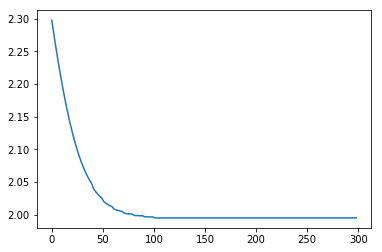

In [10]:
plt.plot(los)

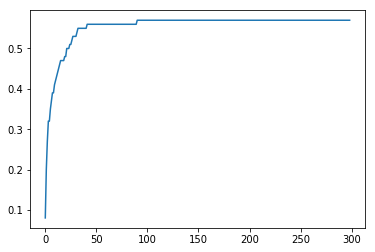

In [11]:
plt.plot(acc)